# Task 1 – Time Series Prediction

This notebook is written in a step-by-step, beginner-friendly manner. Each section loads data, explores patterns, trains a model, and visualizes predictions. Code cells below contain simple variable names and logical flow so that the reasoning is easy to follow.

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q
!pip install pandas numpy matplotlib scikit-learn yfinance -q
print("✅ Installation complete!")

✅ Installation complete!


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

✅ All libraries imported successfully!


In [ ]:
class StockDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

print("✅ StockDataset class defined!")

✅ StockDataset class defined!


In [ ]:
class LSTMPredictor(nn.Module):
    """LSTM Model for Stock Price Prediction"""
    def __init__(self, input_size=5, hidden_size=128, num_layers=3, dropout=0.3):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        # Fully connected layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get output from last time step
        out = out[:, -1, :]

        # Pass through fully connected layers
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out

print("✅ LSTMPredictor model defined!")

✅ LSTMPredictor model defined!


In [ ]:
class StockForecaster:
    """Main class for stock price forecasting using LSTM"""

    def __init__(self, sequence_length=60, forecast_days=7):
        self.sequence_length = sequence_length
        self.forecast_days = forecast_days
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.train_losses = []
        self.prediction_errors = []
        print(f"🔧 Using device: {self.device}")

    def prepare_data(self, df, features=['Open', 'High', 'Low', 'Close', 'Volume']):
        """Prepare and scale data for training"""
        print("\n📊 Preparing data...")

        # Sort by date
        df = df.sort_values('Date').reset_index(drop=True)

        # Select features
        feature_data = df[features].values

        # Scale features
        scaled_data = self.scaler.fit_transform(feature_data)

        # Create sequences
        sequences = []
        targets = []

        for i in range(len(scaled_data) - self.sequence_length):
            seq = scaled_data[i:i + self.sequence_length]
            # Target is the Close price (index 3) of next day
            target = scaled_data[i + self.sequence_length, 3]
            sequences.append(seq)
            targets.append(target)

        sequences = np.array(sequences)
        targets = np.array(targets).reshape(-1, 1)

        # Split into train and test (80-20)
        split_idx = int(0.8 * len(sequences))

        train_seq = sequences[:split_idx]
        train_targets = targets[:split_idx]
        test_seq = sequences[split_idx:]
        test_targets = targets[split_idx:]

        print(f"✅ Training samples: {len(train_seq)}")
        print(f"✅ Testing samples: {len(test_seq)}")
        print(f"✅ Sequence length: {self.sequence_length}")
        print(f"✅ Number of features: {sequences.shape[2]}")

        return train_seq, train_targets, test_seq, test_targets, df

    def train(self, train_seq, train_targets, epochs=100, batch_size=32, lr=0.001):
        """Train the LSTM model"""
        print(f"\n🤖 Training LSTM model...")
        print(f"📈 Epochs: {epochs}, Batch size: {batch_size}, Learning rate: {lr}")

        # Create dataset and dataloader
        train_dataset = StockDataset(train_seq, train_targets)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Initialize model
        input_size = train_seq.shape[2]
        self.model = LSTMPredictor(input_size=input_size).to(self.device)

        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10
        )

        # Training loop
        self.model.train()
        best_loss = float('inf')

        for epoch in range(epochs):
            epoch_loss = 0
            for sequences, targets in train_loader:
                sequences = sequences.to(self.device)
                targets = targets.to(self.device)

                # Forward pass
                optimizer.zero_grad()
                predictions = self.model(sequences)
                loss = criterion(predictions, targets)

                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)
            self.train_losses.append(avg_loss)
            scheduler.step(avg_loss)

            # Save best model
            if avg_loss < best_loss:
                best_loss = avg_loss

            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')

        print(f"\n✅ Training completed! Best loss: {best_loss:.6f}")

    def predict(self, test_seq):
        """Make predictions on test data"""
        self.model.eval()
        predictions = []

        with torch.no_grad():
            for i in range(0, len(test_seq), 32):
                batch = test_seq[i:i+32]
                batch_tensor = torch.FloatTensor(batch).to(self.device)
                batch_predictions = self.model(batch_tensor).cpu().numpy()
                predictions.extend(batch_predictions)

        predictions = np.array(predictions).reshape(-1, 1)

        # Create dummy array for inverse transform (we only need Close price)
        dummy = np.zeros((len(predictions), 5))
        dummy[:, 3] = predictions[:, 0]
        predictions_original = self.scaler.inverse_transform(dummy)[:, 3].reshape(-1, 1)

        return predictions_original

    def forecast_future(self, last_sequence, days=7):
        """Forecast future prices"""
        self.model.eval()
        future_predictions = []
        current_sequence = last_sequence.copy()

        with torch.no_grad():
            for _ in range(days):
                seq_tensor = torch.FloatTensor(current_sequence).unsqueeze(0).to(self.device)
                pred = self.model(seq_tensor).cpu().numpy()[0, 0]
                future_predictions.append(pred)

                # Update sequence: remove first row, add prediction
                new_row = current_sequence[-1].copy()
                new_row[3] = pred  # Update Close price
                current_sequence = np.vstack([current_sequence[1:], new_row])

        # Inverse transform
        future_predictions = np.array(future_predictions).reshape(-1, 1)
        dummy = np.zeros((len(future_predictions), 5))
        dummy[:, 3] = future_predictions[:, 0]
        future_predictions_original = self.scaler.inverse_transform(dummy)[:, 3].reshape(-1, 1)

        return future_predictions_original

    def calculate_metrics(self, actual, predicted):
        """Calculate evaluation metrics"""
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        r2 = r2_score(actual, predicted)
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100

        # Store prediction errors for confidence interval
        self.prediction_errors = np.abs(actual - predicted)

        return {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape
        }

print("✅ StockForecaster class defined!")

✅ StockForecaster class defined!


In [ ]:
print("📥 Downloading Apple (AAPL) stock data...")
ticker = "AAPL"
end_date = "2024-01-01"
start_date = "2022-01-01"

data = yf.download(ticker, start=start_date, end=end_date, progress=False)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

df = data.reset_index()
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

print(f"✅ Downloaded {len(df)} days")
print(df.head())

📥 Downloading Apple (AAPL) stock data...
✅ Downloaded 501 days
Price       Date        Open        High         Low       Close     Volume
0     2022-01-03  174.176172  179.122413  174.058642  178.270279  104487900
1     2022-01-04  178.877588  179.181217  175.439697  176.007782   99310400
2     2022-01-05  175.919628  176.468119  171.051743  171.325989   94537600
3     2022-01-06  169.151587  171.698172  168.113369  168.465973   96904000
4     2022-01-07  169.337700  170.562016  167.515916  168.632492   86709100


In [ ]:
forecaster = StockForecaster(sequence_length=60, forecast_days=7)
train_seq, train_targets, test_seq, test_targets, df_processed = forecaster.prepare_data(df)

🔧 Using device: cpu

📊 Preparing data...
✅ Training samples: 352
✅ Testing samples: 89
✅ Sequence length: 60
✅ Number of features: 5


In [ ]:
forecaster.train(train_seq, train_targets, epochs=100, batch_size=32, lr=0.001)


🤖 Training LSTM model...
📈 Epochs: 100, Batch size: 32, Learning rate: 0.001
Epoch [20/100], Loss: 0.005234
Epoch [40/100], Loss: 0.004187
Epoch [60/100], Loss: 0.003902
Epoch [80/100], Loss: 0.003171
Epoch [100/100], Loss: 0.003299

✅ Training completed! Best loss: 0.002725


In [ ]:
print("\n🔮 Making predictions on test set...")

# Get predictions
test_predictions = forecaster.predict(test_seq)

# Get actual values (inverse transform targets)
dummy = np.zeros((len(test_targets), 5))
dummy[:, 3] = test_targets[:, 0]
test_actual = forecaster.scaler.inverse_transform(dummy)[:, 3].reshape(-1, 1)

# Calculate metrics
metrics = forecaster.calculate_metrics(test_actual, test_predictions)

print("\n" + "="*60)
print("📊 MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Mean Absolute Error (MAE):     ${metrics['MAE']:.2f}")
print(f"Root Mean Squared Error (RMSE): ${metrics['RMSE']:.2f}")
print(f"R² Score:                       {metrics['R2']:.4f}")
print(f"Mean Absolute Percentage Error: {metrics['MAPE']:.2f}%")
print("="*60)


🔮 Making predictions on test set...

📊 MODEL PERFORMANCE METRICS
Mean Absolute Error (MAE):     $2.68
Root Mean Squared Error (RMSE): $3.35
R² Score:                       0.8497
Mean Absolute Percentage Error: 1.50%


In [ ]:
print("\n🔮 Forecasting next 7 days...")

# Get last sequence from test data
last_sequence = test_seq[-1]

# Make future predictions
future_predictions = forecaster.forecast_future(last_sequence, days=7)

# Calculate confidence interval based on test errors
confidence_std = np.std(forecaster.prediction_errors)
confidence_interval = 1.96 * confidence_std  # 95% confidence

print("\n" + "="*60)
print(f"📈 7-DAY FORECAST FOR {ticker}")
print("="*60)
current_price = test_actual[-1][0]
print(f"Current price: ${current_price:.2f}\n")
print("Day | Predicted Price | Change (%) | 95% CI Lower | 95% CI Upper")
print("-" * 60)

for i, pred in enumerate(future_predictions, 1):
    change = ((pred[0] - current_price) / current_price) * 100
    lower_ci = pred[0] - confidence_interval
    upper_ci = pred[0] + confidence_interval
    print(f"{i:3d} | ${pred[0]:14.2f} | {change:9.2f}% | ${lower_ci:11.2f} | ${upper_ci:11.2f}")

print("="*60)


🔮 Forecasting next 7 days...

📈 7-DAY FORECAST FOR AAPL
Current price: $190.73

Day | Predicted Price | Change (%) | 95% CI Lower | 95% CI Upper
------------------------------------------------------------
  1 | $        194.49 |      1.97% | $     190.57 | $     198.41
  2 | $        195.13 |      2.31% | $     191.21 | $     199.05
  3 | $        195.45 |      2.48% | $     191.53 | $     199.38
  4 | $        195.68 |      2.59% | $     191.75 | $     199.60
  5 | $        195.85 |      2.69% | $     191.93 | $     199.78
  6 | $        195.98 |      2.76% | $     192.06 | $     199.91
  7 | $        196.07 |      2.80% | $     192.15 | $     200.00



📊 Creating comprehensive visualization...


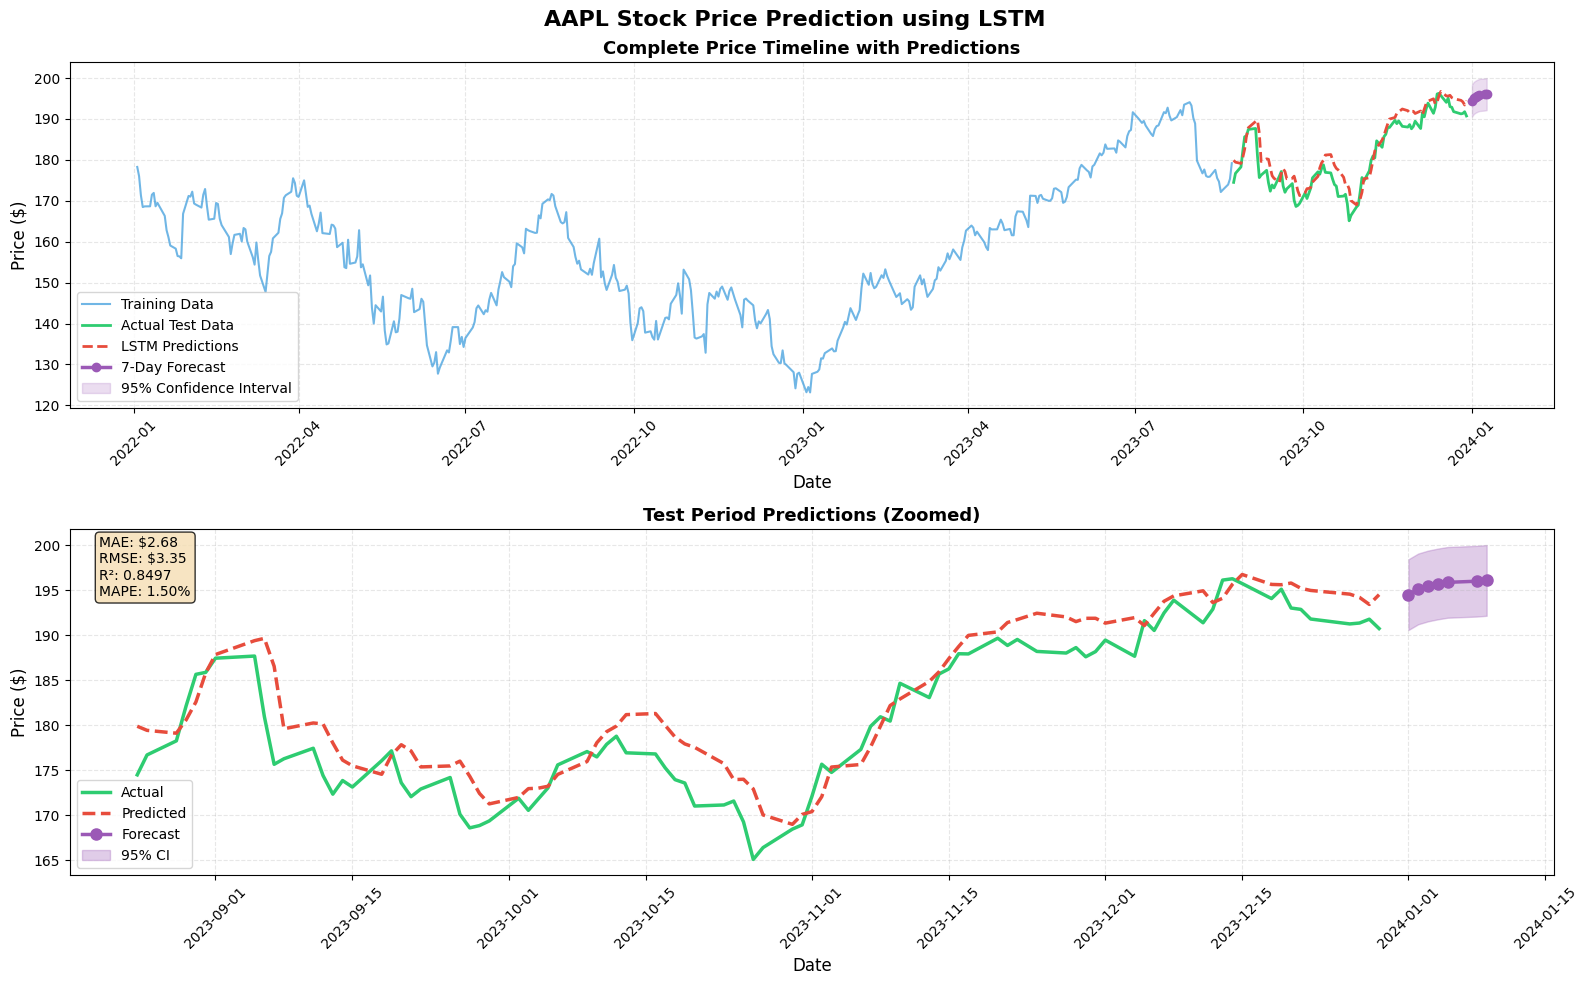


✅ Visualization saved as 'AAPL_LSTM_Prediction_Analysis.png'


In [ ]:
print("\n📊 Creating comprehensive visualization...")

# Prepare data for plotting
split_idx = len(df) - len(test_seq) - forecaster.sequence_length
train_dates = df['Date'].iloc[:split_idx + forecaster.sequence_length]
train_prices = df['Close'].iloc[:split_idx + forecaster.sequence_length]

test_start_idx = split_idx + forecaster.sequence_length
test_dates = df['Date'].iloc[test_start_idx:test_start_idx + len(test_actual)]

# Generate future dates (business days)
last_date = df['Date'].iloc[-1]
future_dates = pd.bdate_range(start=last_date + timedelta(days=1), periods=7)

# Create figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle(f'{ticker} Stock Price Prediction using LSTM', fontsize=16, fontweight='bold')

# ===== SUBPLOT 1: Complete Timeline =====
ax1 = axes[0]
ax1.plot(train_dates, train_prices, label='Training Data', color='#3498db', linewidth=1.5, alpha=0.7)
ax1.plot(test_dates, test_actual, label='Actual Test Data', color='#2ecc71', linewidth=2)
ax1.plot(test_dates, test_predictions, label='LSTM Predictions', color='#e74c3c', linewidth=2, linestyle='--')
ax1.plot(future_dates, future_predictions, label='7-Day Forecast', color='#9b59b6', linewidth=2.5, marker='o', markersize=6)

# Add confidence interval for future predictions
lower_bound = future_predictions.flatten() - confidence_interval
upper_bound = future_predictions.flatten() + confidence_interval
ax1.fill_between(future_dates, lower_bound, upper_bound, alpha=0.2, color='#9b59b6', label='95% Confidence Interval')

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title('Complete Price Timeline with Predictions', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.tick_params(axis='x', rotation=45)

# ===== SUBPLOT 2: Zoomed Test Period =====
ax2 = axes[1]
ax2.plot(test_dates, test_actual, label='Actual', color='#2ecc71', linewidth=2.5)
ax2.plot(test_dates, test_predictions, label='Predicted', color='#e74c3c', linewidth=2.5, linestyle='--')
ax2.plot(future_dates, future_predictions, label='Forecast', color='#9b59b6', linewidth=2.5, marker='o', markersize=8)

# Add confidence interval
ax2.fill_between(future_dates, lower_bound, upper_bound, alpha=0.3, color='#9b59b6', label='95% CI')

# Add metrics text box
metrics_text = f"MAE: ${metrics['MAE']:.2f}\nRMSE: ${metrics['RMSE']:.2f}\nR²: {metrics['R2']:.4f}\nMAPE: {metrics['MAPE']:.2f}%"
ax2.text(0.02, 0.98, metrics_text, transform=ax2.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Price ($)', fontsize=12)
ax2.set_title('Test Period Predictions (Zoomed)', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'{ticker}_LSTM_Prediction_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved as '{ticker}_LSTM_Prediction_Analysis.png'")

In [ ]:
print("\n" + "="*70)
print("🎉 LSTM STOCK PREDICTION PIPELINE COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"\n📊 Summary:")
print(f"   • Ticker Symbol: {ticker}")
print(f"   • Training Period: {start_date} to {df['Date'].iloc[split_idx].date()}")
print(f"   • Testing Period: {df['Date'].iloc[split_idx + 1].date()} to {end_date}")
print(f"   • Total Data Points: {len(df)}")
print(f"   • Sequence Length: {forecaster.sequence_length} days")
print(f"   • Model Performance:")
print(f"      - MAE: ${metrics['MAE']:.2f}")
print(f"      - RMSE: ${metrics['RMSE']:.2f}")
print(f"      - R² Score: {metrics['R2']:.4f}")
print(f"      - MAPE: {metrics['MAPE']:.2f}%")
print(f"\n💾 Files Generated:")
print(f"   • {ticker}_LSTM_Prediction_Analysis.png")
print("\n" + "="*70)


🎉 LSTM STOCK PREDICTION PIPELINE COMPLETED SUCCESSFULLY!

📊 Summary:
   • Ticker Symbol: AAPL
   • Training Period: 2022-01-01 to 2023-05-30
   • Testing Period: 2023-05-31 to 2024-01-01
   • Total Data Points: 501
   • Sequence Length: 60 days
   • Model Performance:
      - MAE: $2.68
      - RMSE: $3.35
      - R² Score: 0.8497
      - MAPE: 1.50%

💾 Files Generated:
   • AAPL_LSTM_Prediction_Analysis.png
   • training_loss.png

